# Amazon Food Reviews NLP

This dataset contains raw text reviews of "fine food reviews" from Amazon over more than 10 years.
A product rating is provided as a value between 1 and 5.  This notebook will exploring training various algorithms to predict the rating of a review based on its review text.

## Potential Approaches

I'm thinking about three different approaches here.  

- __1__ - Use regression techniques to predict a continous output between 0 and 4 (normalized).  This approach intends for an algorithm to learn review sentiment encoded as this output value. For this approach, I'll explore using various regression techniques, including logistic regression and neural networks.  For a simple NN, a single sigmoid node could represent the output.

- __2__ - create a binary classifier that predicts discrete values of 0 or 1, considering reviews with 1, 2, or 3 stars as "negative reviews" and 4 or 5 stars as "positive reviews".

- __3__ - Treat the problem as a classification problem, and build a classifier that predicts each review was one of five classes.  This seems most unintuitive, but I suspect that it is worth exploring.  Here, I consider using a CNN to build a classifier with the output as a one-hot encoding of the rating.  Alternatively, I may consider building 5 binary classifiers to distinguish between classes.


In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import re

import pandas as pd
import seaborn as sns
import matplotlib
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
sns.set(style='dark', palette='muted', font_scale=1.2, rc={'figure.figsize': [16, 6]})

## Raw Data

### Amazon Fine Food Reviews Dataset

Download Amazon Fine Food Reviews Dataset

> https://www.kaggle.com/snap/amazon-fine-food-reviews

In [4]:
AMZ_FOOD_DIR = 'amz_data'
AMZ_FOOD_CSV = 'food_reviews.csv'
DATA_AMZ_FOOD = os.path.join(AMZ_FOOD_DIR, AMZ_FOOD_CSV)

In [5]:
df = pd.read_csv(DATA_AMZ_FOOD)

# get a subset of data to run as draft
df = df[:10_000]

## Feature Inspection

In [6]:
df.shape

(10000, 10)

In [7]:
df.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      10000 non-null  int64 
 1   ProductId               10000 non-null  object
 2   UserId                  10000 non-null  object
 3   ProfileName             10000 non-null  object
 4   HelpfulnessNumerator    10000 non-null  int64 
 5   HelpfulnessDenominator  10000 non-null  int64 
 6   Score                   10000 non-null  int64 
 7   Time                    10000 non-null  int64 
 8   Summary                 10000 non-null  object
 9   Text                    10000 non-null  object
dtypes: int64(5), object(5)
memory usage: 781.4+ KB


## Target Data Inspection

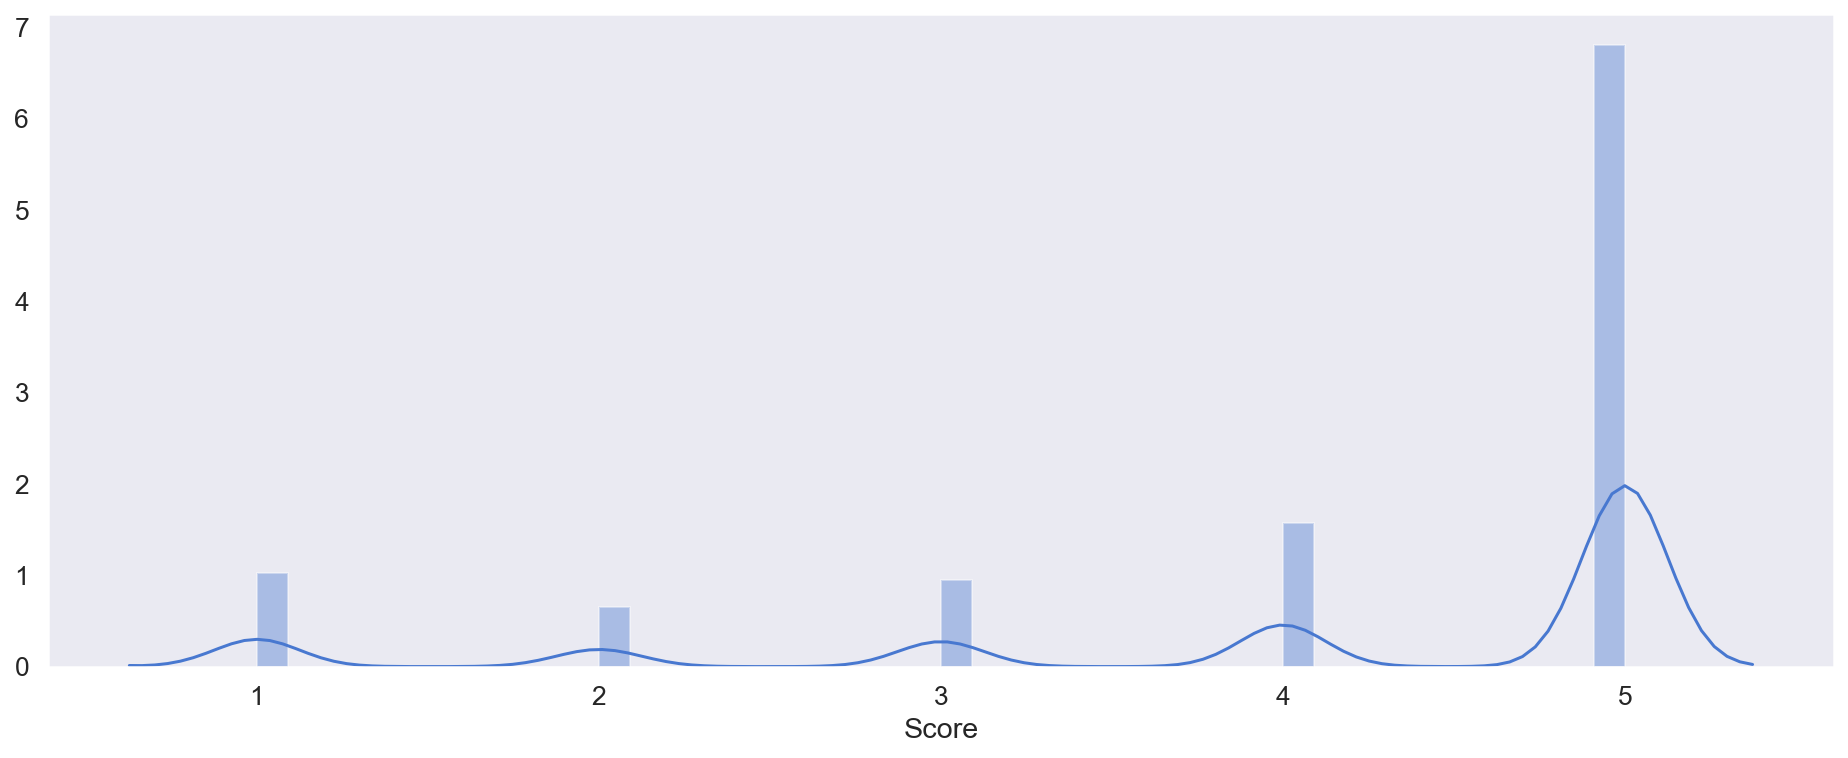

In [9]:
sns.distplot(df.Score)

Inspecting the distribution of target values, it's clear that we have heavily imbalanced data.

### The Problem with Imbalanced Classes

Typically, we want balanced classes to train machine learning models. Many algorithms work to maximize accuracy. Think about accuracy as a metric - we could just predict the value of the review to be 5.0 and already achieve ~65% accuracy, much higher than random choice in this case.

### Approaches to rectifying

- undersample majority class
- oversample minority classes
- generate synthetic data

Since the size of the data is small, oversampling minority classes may be a good approach.  I will first explore generating synthetic data using `SMOTE`, or Synthetic Minority Oversampling Technique, which seems interesting.

Reference: https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-14-106

## Data Preprocessing

Here I would like to clean up the data I intend to work with and discard unwanted features

In [10]:
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

### Clean Features

- drop irrelevant
- drop duplicates
- encode categorical
- handle NaN values

In [11]:
# Drop unwanted features

df.drop(['Id', 'UserId', 'ProfileName', 'ProductId', 'Summary', 'Time'], axis=1, inplace=True)

In [12]:
# rename features to preference

col_rename_map = {
    'HelpfulnessNumerator': 'helpful_count',
    'HelpfulnessDenominator': 'helpful_total',
    'Score': 'score',
    'Text': 'review_text',
}

df.rename(columns=col_rename_map, inplace=True)
df.head(3)
print('DataFrame shape is:', df.shape)

DataFrame shape is: (10000, 4)


In [13]:
# observe duplicate reviews

df[df.duplicated(['review_text'], keep=False)]

,helpful_count,helpful_total,score,review_text
10,1,1,5,I don't know if it's the cactus or the tequila...
29,1,1,5,I don't know if it's the cactus or the tequila...
251,0,0,3,The pork chops from Omaha Steaks were very tas...
466,0,0,5,"I'm addicted to salty and tangy flavors, so wh..."
574,2,2,5,"I'm addicted to salty and tangy flavors, so wh..."
...,...,...,...,...
9443,1,1,4,Our Keurig coffee maker was a great Christmas ...
9444,1,1,3,This coffee is okay but certainly not as good ...
9445,1,1,3,"This is a great flavored coffee nevertheless, ..."
9446,1,1,4,I roast my own Colombian beans at home so I ha...


In [14]:
# drop dupes

prev_rowcount = df.shape[0]

df = df.drop_duplicates(subset={"review_text"})
print(f'Removed {prev_rowcount - df.shape[0]} duplicate reviews.')

Removed 487 duplicate reviews.


In [15]:
# check for missing values

df.isna().sum()

helpful_count    0
helpful_total    0
score            0
review_text      0
dtype: int64

Depending on the subsample from this data, there are no or very few rows containing missing data. 

Dropping these rather than imputing.

In [16]:
prev_rowcount = df.shape[0]
df.dropna(inplace=True)
new_rowcount = df.shape[0]
print(f'Dropped {new_rowcount - prev_rowcount} rows containing missing values')

Dropped 0 rows containing missing values


In [17]:
# Define a function to segment the sentiment of a rating

def segment_sentiment(val):
    if val in [1, 2, 3]:
        return 0
    return 1

In [18]:
df['sentiment'] = df['score'].apply(segment_sentiment)

In [19]:
# Inspect data after cleaning

df.head()

,helpful_count,helpful_total,score,review_text,sentiment
0,1,1,5,I have bought several of the Vitality canned d...,1
1,0,0,1,Product arrived labeled as Jumbo Salted Peanut...,0
2,1,1,4,This is a confection that has been around a fe...,1
3,3,3,2,If you are looking for the secret ingredient i...,0
4,0,0,5,Great taffy at a great price. There was a wid...,1


## Basic text preprocessing

### Clean up Review and Summary text data

In [20]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

Create a function to clean up strings

Apply the function to `summary_text` and `review_text` columns

In [21]:
def clean_str(string):
    string = re.sub(r"\b\w{,3}\b", "", string)
    string = re.sub(r"\\", "", string)    
    string = re.sub(r"\'", "", string)    
    string = ' '.join([w for w in string.split() if len(w)>3])
    return string.strip().lower()

In [22]:
df['review_text'] = df['review_text'].astype(str).apply(clean_str)
df['review_text'].head(8)

0    have bought several vitality canned food produ...
1    product arrived labeled jumbo salted peanuts.....
2    this confection that been around centuries. li...
3    looking secret ingredient robitussin believe h...
4    great taffy great price. there wide assortment...
5    wild hair taffy ordered this five pound taffy ...
6    this saltwater taffy great flavors very soft c...
7    this taffy good. very soft chewy. flavors amaz...
Name: review_text, dtype: object

### Tokenize Text Data

Keras provides a builtin `Tokenizer` that can be used for the purpose of tokenizing raw clean strings

In [23]:
sents = df['review_text']

In [24]:
# Specify max vocab size

VOCAB_SIZE = 20_000

tokenizer = Tokenizer(nb_words=VOCAB_SIZE)
tokenizer.fit_on_texts(sents)
sequences = tokenizer.texts_to_sequences(sents)

In [25]:
# peak at part of a sequence

np.asarray(sequences)[0][:8]

[4, 65, 220, 6253, 438, 26, 119, 4]

In [26]:
word_index = tokenizer.word_index
print(f'{len(word_index)} unique tokens in data.')

17518 unique tokens in data.


In [27]:
# each word now has a corresponding value. peak at the word index

word_index['good']

8

### Determine a Maximum Sequence Length

The reviews naturally have different lengths.  It would be ideal for downstream neural network models to accept tensors of the same size.  We can choose a maximum sequence length and pad sequences using Keras.

To choose the maximum length, I'll look at the distribution of length of reviews.

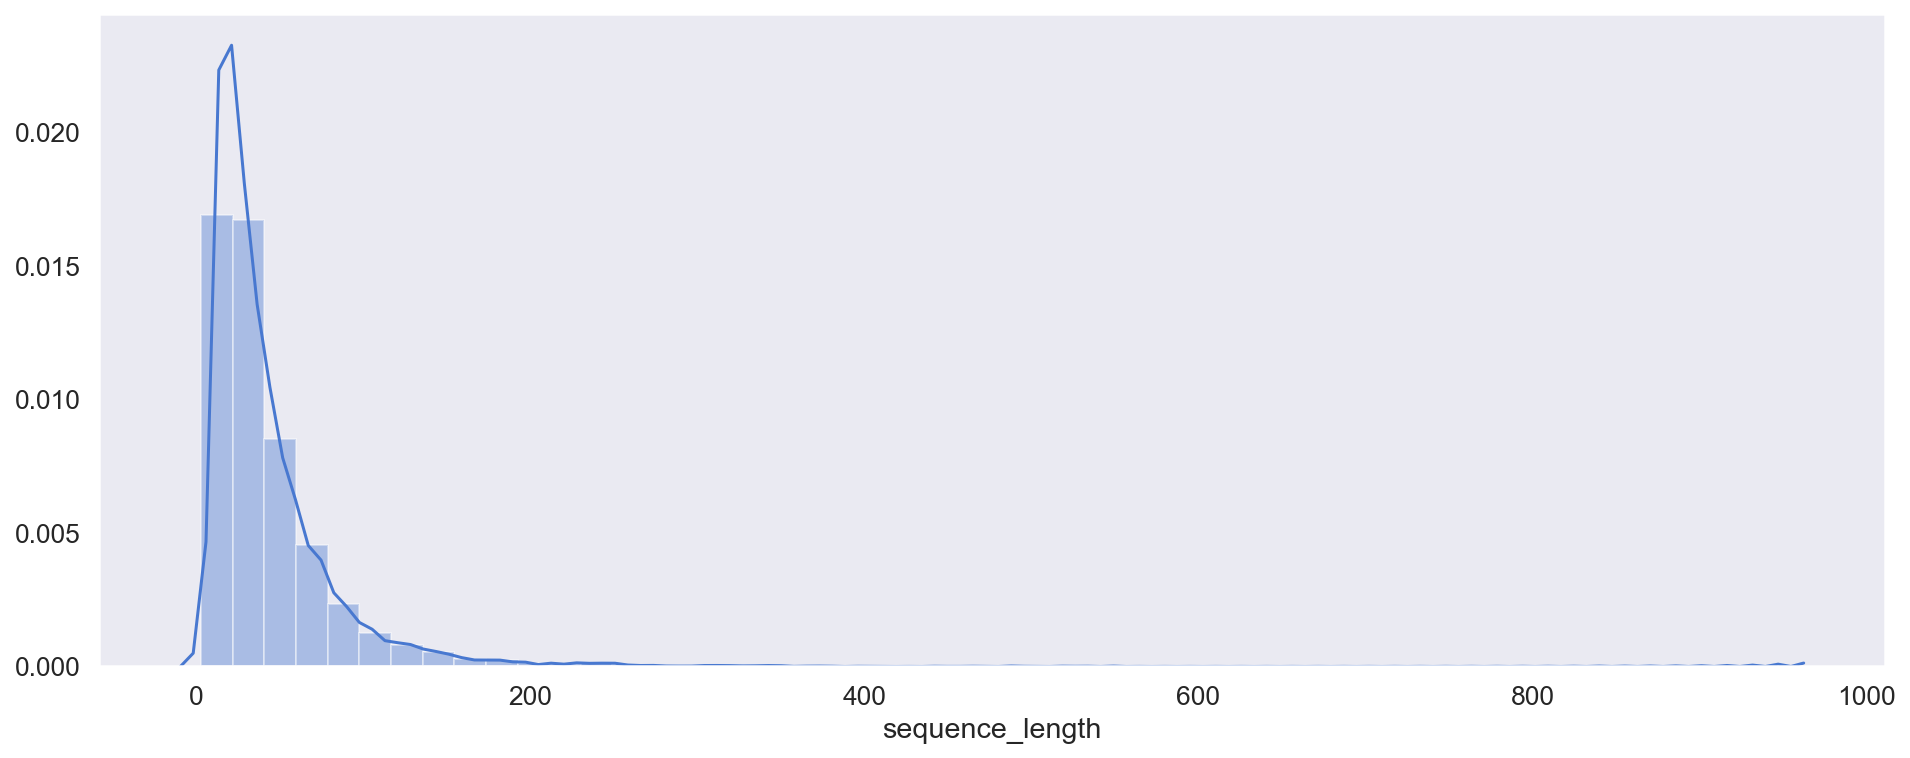

In [28]:
df['sequences'] = sequences
df['sequence_length'] = df['sequences'].apply(len)

sns.distplot(df.sequence_length)

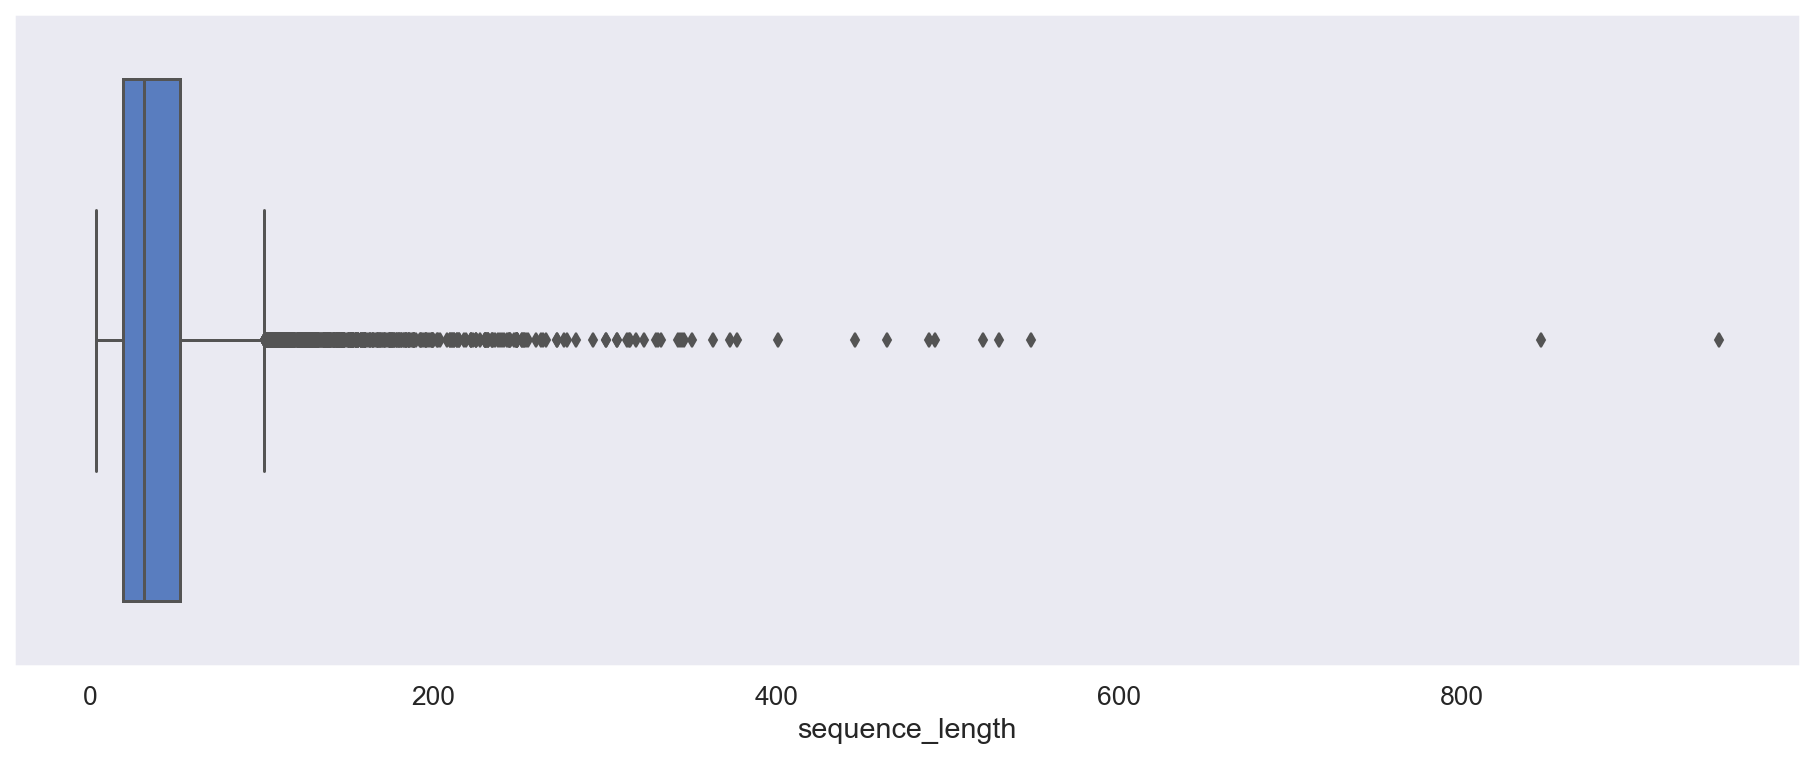

In [29]:
sns.boxplot(df.sequence_length)

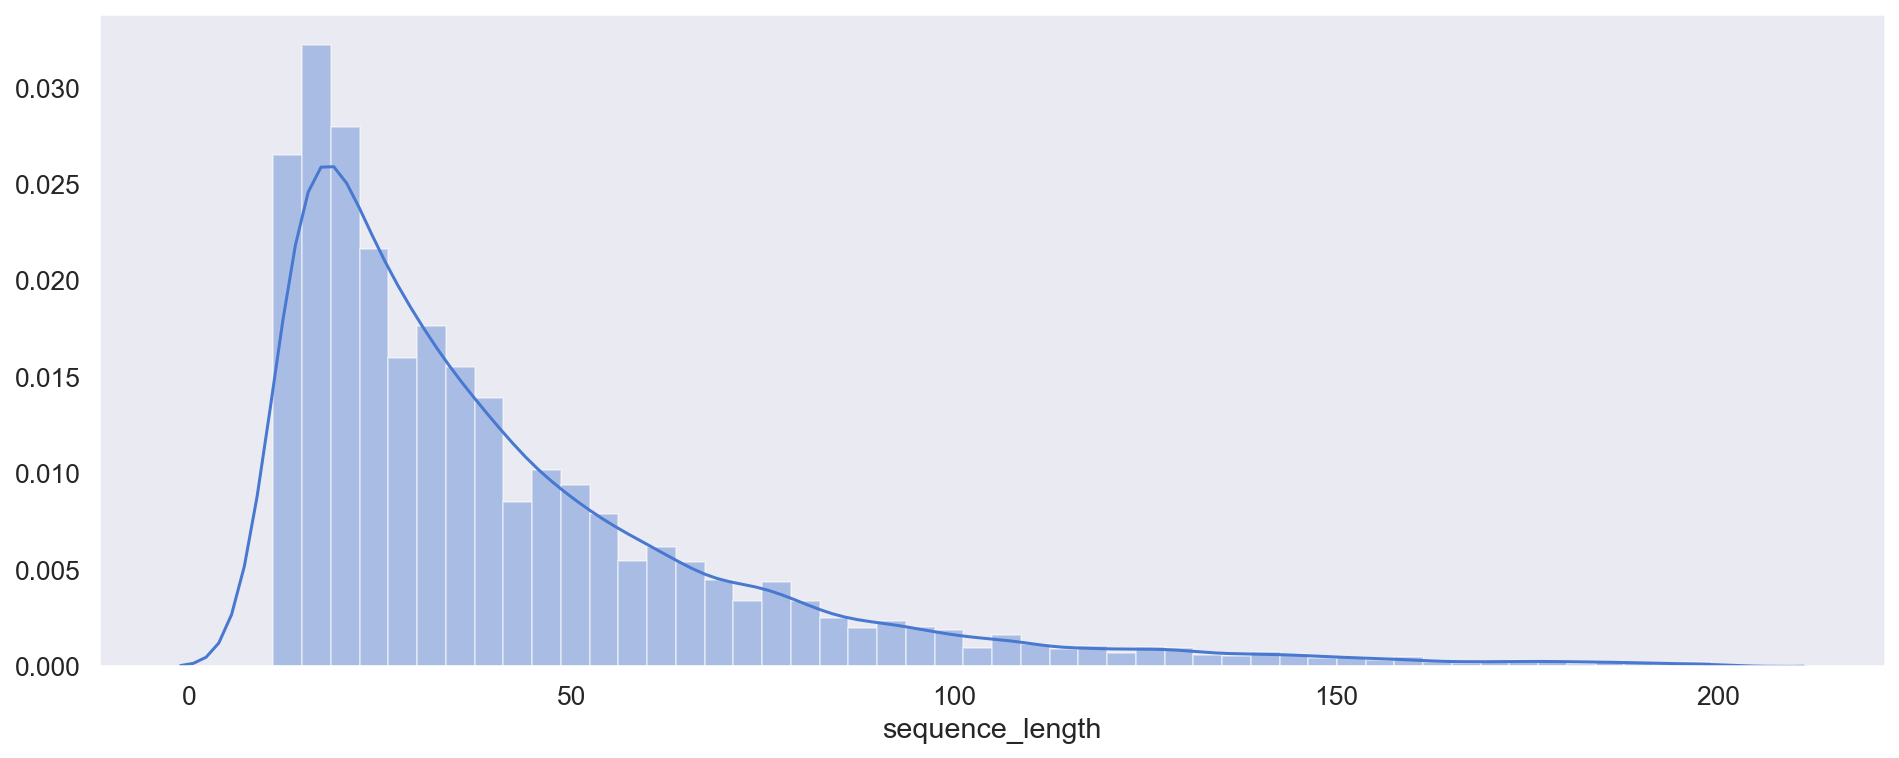

In [30]:
# Look at the distribution of length where length between 10 and 175
sns.distplot(df[(df.sequence_length < 200) & (df.sequence_length > 10)].sequence_length)

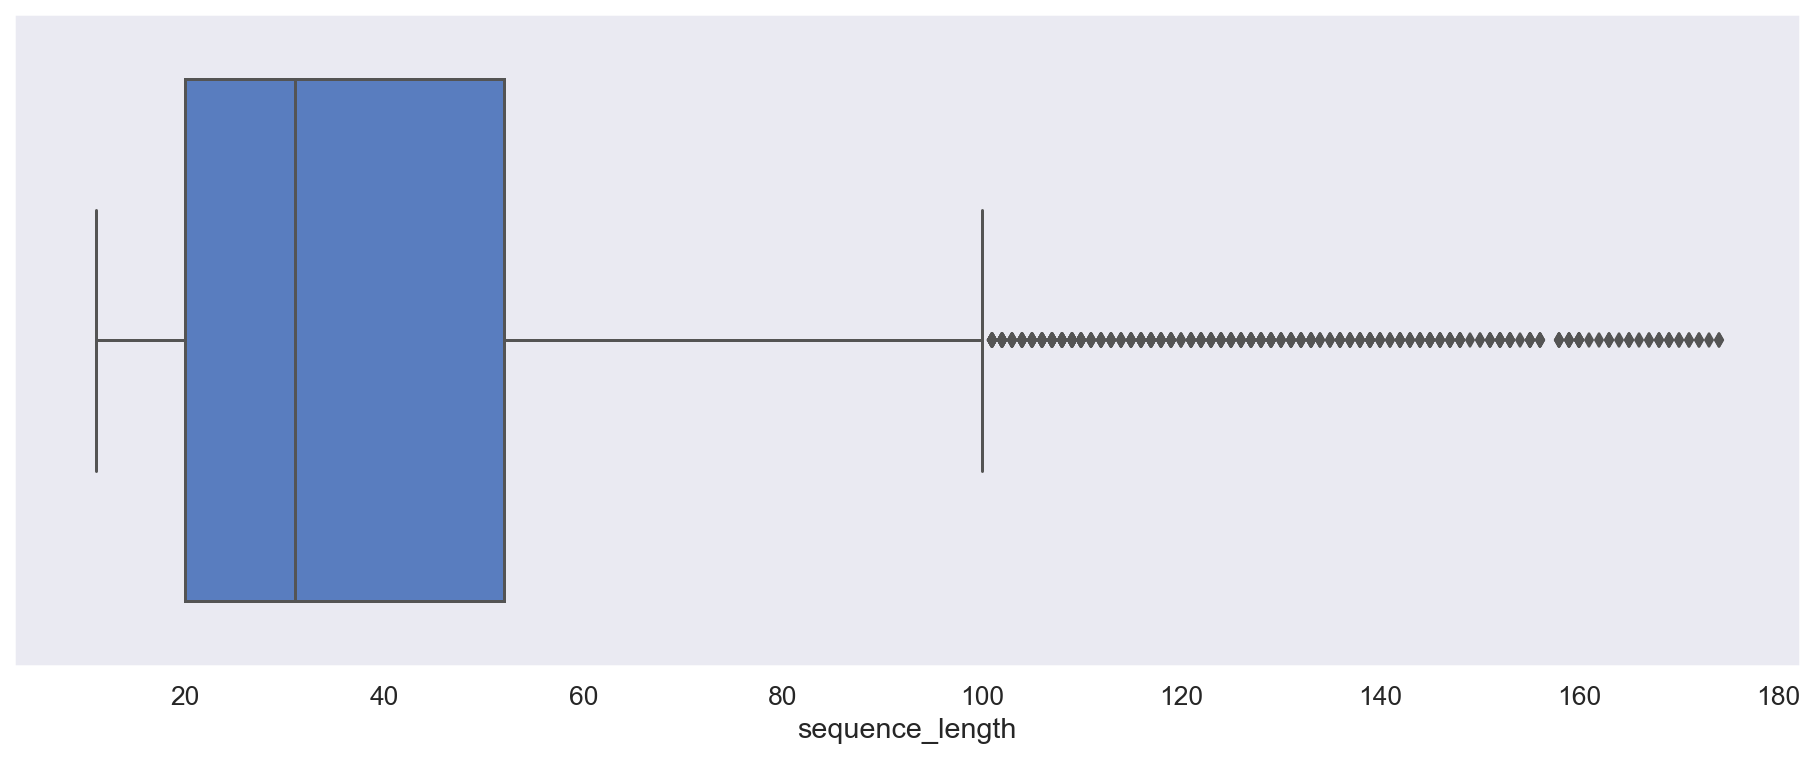

In [31]:
sns.boxplot(df[(df.sequence_length < 175) & (df.sequence_length > 10)].sequence_length)

In [32]:
MAX_SEQUENCE_LENGTH = 200
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [33]:
data[:10]

array([[   0,    0,    0, ...,   44,   23,   83],
       [   0,    0,    0, ..., 7515,   14, 2639],
       [   0,    0,    0, ..., 1602, 4856, 7517],
       ...,
       [   0,    0,    0, ...,  156,   15,  837],
       [   0,    0,    0, ...,  215,    3, 3566],
       [   0,    0,    0, ...,  218,  100,  622]], dtype=int32)

In [34]:
data.shape

(9513, 200)

### Inspect current data

In [35]:
df.head()

,helpful_count,helpful_total,score,review_text,sentiment,sequences,sequence_length
0,1,1,5,have bought several vitality canned food produ...,1,"[4, 65, 220, 6253, 438, 26, 119, 4, 61, 9, 8, ...",30
1,0,0,1,product arrived labeled jumbo salted peanuts.....,0,"[14, 253, 2153, 2639, 1713, 945, 945, 33, 176,...",20
2,1,1,4,this confection that been around centuries. li...,1,"[1, 4070, 2, 49, 215, 9863, 221, 9864, 1049, 3...",52
3,3,3,2,looking secret ingredient robitussin believe h...,0,"[147, 2641, 396, 7519, 359, 4, 61, 1, 720, 221...",22
4,0,0,5,great taffy great price. there wide assortment...,1,"[13, 2449, 13, 42, 32, 2070, 2071, 472, 2449, ...",17


### One-Hot Encode Labels

Our labels are currently numbers 1, 2, 3, 4, 5, corresponding to the number of stars a reviewer gave a product.

For certain models, we may use the simplified `sentiment` value to predict if a review is positive or negative.  In the case of discrete classifications, we should one-hot encode the score.

Downstream n-classification models will generally perform better with one-hot encoded vectors.

In [36]:
# Re-index labels to start at 0 (to_categorical expects this)

labels_1h = np.subtract(df.score, 1)

In [37]:
np.unique(labels_1h)

array([0, 1, 2, 3, 4])

In [38]:
labels_1h = to_categorical(labels_1h)

In [39]:
labels_1h

array([[0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.]], dtype=float32)

## Split Data into Train and Test groups

Here, I'll use `data` (sequences) for features, `labels-1h` for target values in the case of one-hot encoding problems for n-classifiers, and `labels` for binary classification.

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

In [41]:
labels = df.sentiment

In [42]:
VALIDATION_SPLIT = 0.18

print('Shape of data tensor:', data.shape)
print('Shape of one-hot labels tensor:', labels_1h.shape)
print('Shape of binary labels tensor:', labels.shape)

Shape of data tensor: (9513, 200)
Shape of one-hot labels tensor: (9513, 5)
Shape of binary labels tensor: (9513,)


In [43]:
X_train, X_test, y_train_1h, y_test_1h = train_test_split(data, labels_1h, test_size=VALIDATION_SPLIT, random_state=8)
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=VALIDATION_SPLIT, random_state=8)

In [44]:
print(f'X_train: {X_train.shape}')
print(f'X_test:  {X_test.shape}')
print(f'y_train: {y_train.shape}')
print(f'y_test:  {y_test.shape}')
print(f'y_train_1h: {y_train.shape}')
print(f'y_test_1h:  {y_test.shape}')

X_train: (7800, 200)
X_test:  (1713, 200)
y_train: (7800,)
y_test:  (1713,)
y_train_1h: (7800,)
y_test_1h:  (1713,)


## Model Selection

I will begin by using GloVe to build word vectors for the raw text.

### Load GloVe vectors to build embedding layer of CNN

The standard pre-trained GloVe Wikipedia 2014 + GigaWord 5 set contains 6B tokens, 400K vocab size, and optional word embedding dimensions of 50, 100, 200, and 300.

I'll choose the 100-dimension vectors for this model.

In [45]:
from os.path import expanduser

HOME_DIR = expanduser("~")
GLOVE_DIR = "data/glove.6B"

embeddings_index = {}

with open(os.path.join(HOME_DIR, GLOVE_DIR, 'glove.6B.100d.txt')) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [46]:
print('Total %s word vectors in Glove 6B 100d.' % len(embeddings_index))

Total 400000 word vectors in Glove 6B 100d.


In [47]:
EMBEDDING_DIM = 100

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

## CNN Text Classifier

This CNN architecture is adapted from the simple CNN described in Richard Liao's blog article:

> (https://richliao.github.io/supervised/classification/2016/11/26/textclassifier-convolutional/)

which follows the example from:

> (https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html)

For the discrete 5-category classifier, I will modify the output layer to match the label shape for this problem.

I have modified the architecture described in that article to make the number of filters in each convolutional layer significantly smaller, to see the effect on initial model performance.

Note also that the `Conv1D` layer from Keras may require non-default `data_format` parameter to be set to `'channels_first'`.  The default value is `'channels_last'`, but this throws an exception on my Macbook Pro (quad-core i7)

In [48]:
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Conv1D, MaxPooling1D, Dropout
from tensorflow.keras.models import Model, Sequential

In [49]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)

### 5-class CNN classifier

In [50]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

l_cov1= Conv1D(64, 5, activation='relu')(embedded_sequences)
l_pool1 = MaxPooling1D(5, data_format='channels_first')(l_cov1)
l_cov2 = Conv1D(64, 5, activation='relu')(l_pool1)
l_pool2 = MaxPooling1D(5, data_format='channels_first')(l_cov2)
l_cov3 = Conv1D(128, 5, activation='relu')(l_pool2)
l_pool3 = MaxPooling1D(35, data_format='channels_first')(l_cov3)  # global max pooling
l_flat = Flatten()(l_pool3)
l_dense = Dense(64, activation='relu')(l_flat)
preds = Dense(5, activation='softmax')(l_dense)

In [51]:
model_5n = Model(sequence_input, preds)

model_5n.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

model_5n.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 200, 100)          1751900   
_________________________________________________________________
conv1d (Conv1D)              (None, 196, 64)           32064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 196, 12)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 192, 64)           3904      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 192, 12)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 188, 128)          7808  

In [52]:
model_5n.save_weights('cnn_5n_initialized_weights.h5')

### CNN binary classifier

In [50]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

l_cov1= Conv1D(64, 5, activation='relu')(embedded_sequences)
l_pool1 = MaxPooling1D(5, data_format='channels_first')(l_cov1)
l_cov2 = Conv1D(64, 5, activation='relu')(l_pool1)
l_pool2 = MaxPooling1D(5, data_format='channels_first')(l_cov2)
l_cov3 = Conv1D(128, 5, activation='relu')(l_pool2)
l_pool3 = MaxPooling1D(35, data_format='channels_first')(l_cov3)  # global max pooling
l_flat = Flatten()(l_pool3)
l_dense = Dense(64, activation='relu')(l_flat)
preds = Dense(2, activation='softmax')(l_dense)

In [51]:
model_2n = Model(sequence_input, preds)

model_2n.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

model_2n.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 200, 100)          1751900   
_________________________________________________________________
conv1d (Conv1D)              (None, 196, 64)           32064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 196, 12)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 192, 64)           3904      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 192, 12)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 188, 128)          7808  

In [52]:
model_2n.save_weights('cnn_2n_initialized_weights.h5')

### Training the binary classifier CNN

In [53]:
y_train_re = to_categorical(y_train)
y_test_re = to_categorical(y_test)

In [54]:
cnn_history = model_2n.fit(X_train, y_train_re, validation_data=(X_test, y_test_re), epochs=10, batch_size=64)

Train on 7800 samples, validate on 1713 samples
Epoch 1/10
7800/7800 [==============================] - 10s 1ms/sample - loss: 0.5819 - acc: 0.7510 - val_loss: 0.5334 - val_acc: 0.7554
Epoch 2/10
7800/7800 [==============================] - 9s 1ms/sample - loss: 0.4855 - acc: 0.7646 - val_loss: 0.4748 - val_acc: 0.7747
Epoch 3/10
7800/7800 [==============================] - 11s 1ms/sample - loss: 0.4200 - acc: 0.8005 - val_loss: 0.4350 - val_acc: 0.8091
Epoch 4/10
7800/7800 [==============================] - 11s 1ms/sample - loss: 0.3618 - acc: 0.8379 - val_loss: 0.4548 - val_acc: 0.8015
Epoch 5/10
7800/7800 [==============================] - 10s 1ms/sample - loss: 0.3121 - acc: 0.8671 - val_loss: 0.4038 - val_acc: 0.8167
Epoch 6/10
7800/7800 [==============================] - 10s 1ms/sample - loss: 0.2641 - acc: 0.8878 - val_loss: 0.4651 - val_acc: 0.7595
Epoch 7/10
7800/7800 [==============================] - 13s 2ms/sample - loss: 0.2132 - acc: 0.9169 - val_loss: 0.4721 - val_acc: 0

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


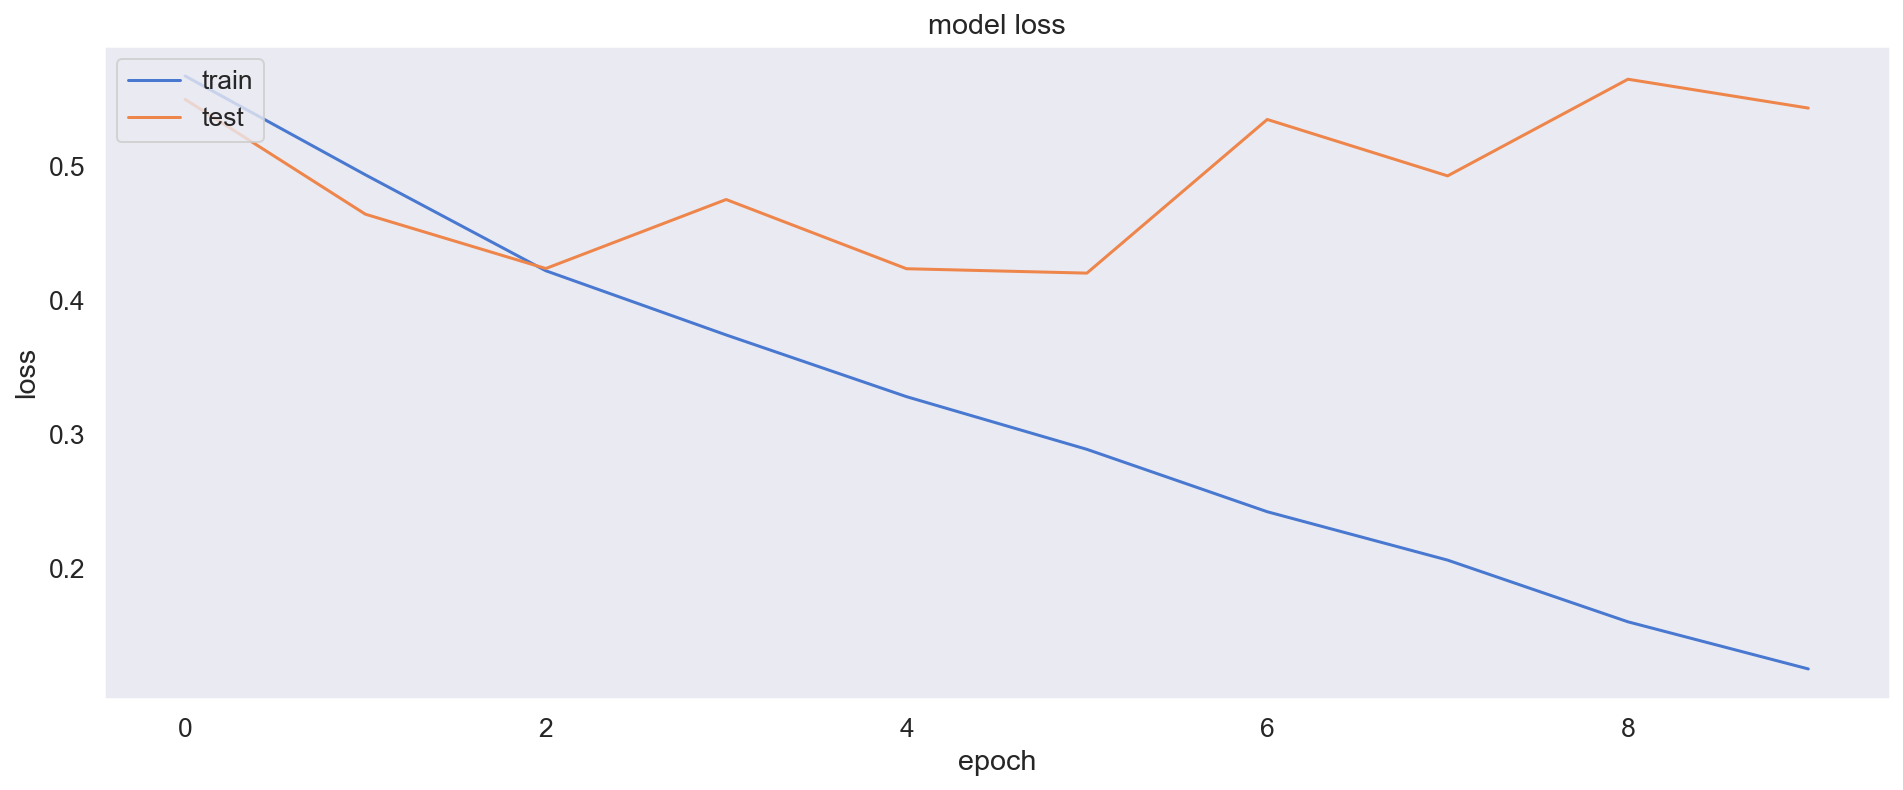

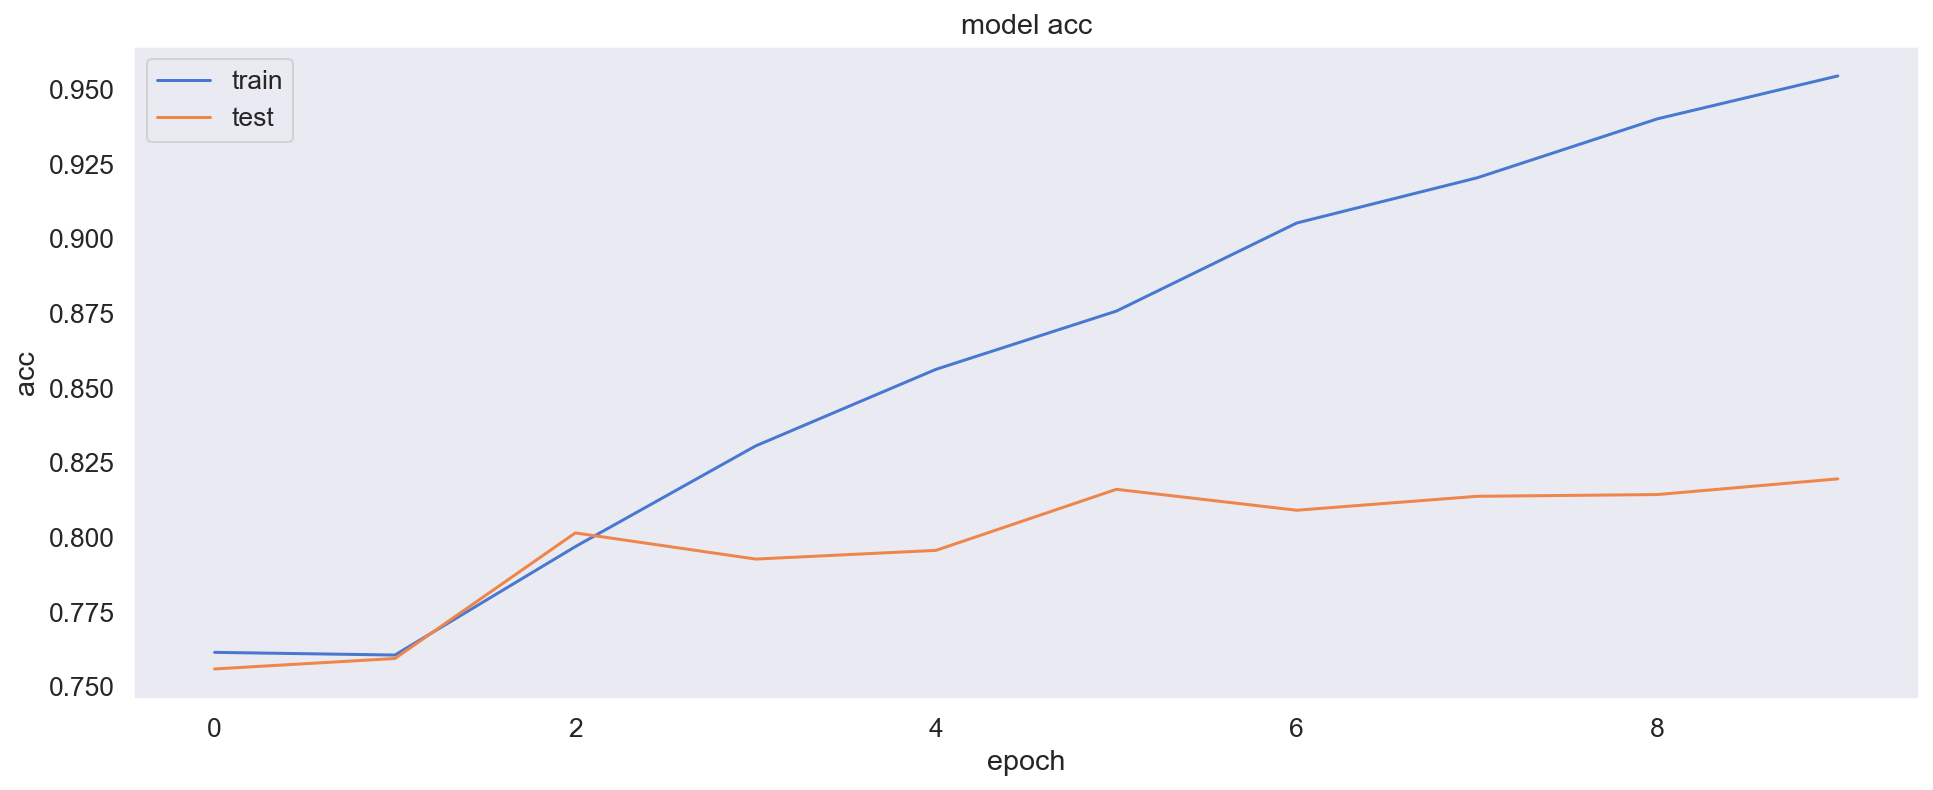

In [58]:
print(cnn_history.history.keys())
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(cnn_history.history['acc'])
plt.plot(cnn_history.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Save CNN weights

In [55]:
model_2n.save_weights("cnn_2n_initialized_weights_10_epochs.h5")

### CNN binary classifier v2 - Add Dropout

I would like to apply dropout layers to the model to attempt to reduce overfitting

In [56]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

l_cov1= Conv1D(64, 5, activation='relu')(embedded_sequences)
l_pool1 = MaxPooling1D(5, data_format='channels_first')(l_cov1)
l_drop1 = Dropout(0.5)(l_pool1)

l_cov2 = Conv1D(64, 5, activation='relu')(l_drop1)
l_pool2 = MaxPooling1D(5, data_format='channels_first')(l_cov2)
l_drop2 = Dropout(0.5)(l_pool2)

l_cov3 = Conv1D(128, 5, activation='relu')(l_drop2)
l_pool3 = MaxPooling1D(35, data_format='channels_first')(l_cov3)  # global max pooling
l_flat = Flatten()(l_pool3)

l_dense = Dense(64, activation='relu')(l_flat)
preds = Dense(2, activation='softmax')(l_dense)

In [57]:
model_2n_v2 = Model(sequence_input, preds)

model_2n_v2.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

model_2n_v2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 200, 100)          1751900   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 196, 64)           32064     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 196, 12)           0         
_________________________________________________________________
dropout (Dropout)            (None, 196, 12)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 192, 64)           3904      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 192, 12)           0   

In [58]:
model_2n_v2.save_weights('cnn_2n_v2_initialized_weights.h5')

In [59]:
cnn_history_v2 = model_2n_v2.fit(X_train, y_train_re, validation_data=(X_test, y_test_re), epochs=10, batch_size=64)

Train on 7800 samples, validate on 1713 samples
Epoch 1/10
7800/7800 [==============================] - 10s 1ms/sample - loss: 0.5548 - acc: 0.7581 - val_loss: 0.4991 - val_acc: 0.7560
Epoch 2/10
7800/7800 [==============================] - 9s 1ms/sample - loss: 0.4252 - acc: 0.7881 - val_loss: 0.4515 - val_acc: 0.7881
Epoch 3/10
7800/7800 [==============================] - 10s 1ms/sample - loss: 0.3603 - acc: 0.8353 - val_loss: 0.4362 - val_acc: 0.8015
Epoch 4/10
7800/7800 [==============================] - 11s 1ms/sample - loss: 0.3138 - acc: 0.8642 - val_loss: 0.4098 - val_acc: 0.8179
Epoch 5/10
7800/7800 [==============================] - 11s 1ms/sample - loss: 0.2914 - acc: 0.8742 - val_loss: 0.4120 - val_acc: 0.8237
Epoch 6/10
7800/7800 [==============================] - 11s 1ms/sample - loss: 0.2662 - acc: 0.8905 - val_loss: 0.4116 - val_acc: 0.8214
Epoch 7/10
7800/7800 [==============================] - 11s 1ms/sample - loss: 0.2406 - acc: 0.8985 - val_loss: 0.4154 - val_acc: 0

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


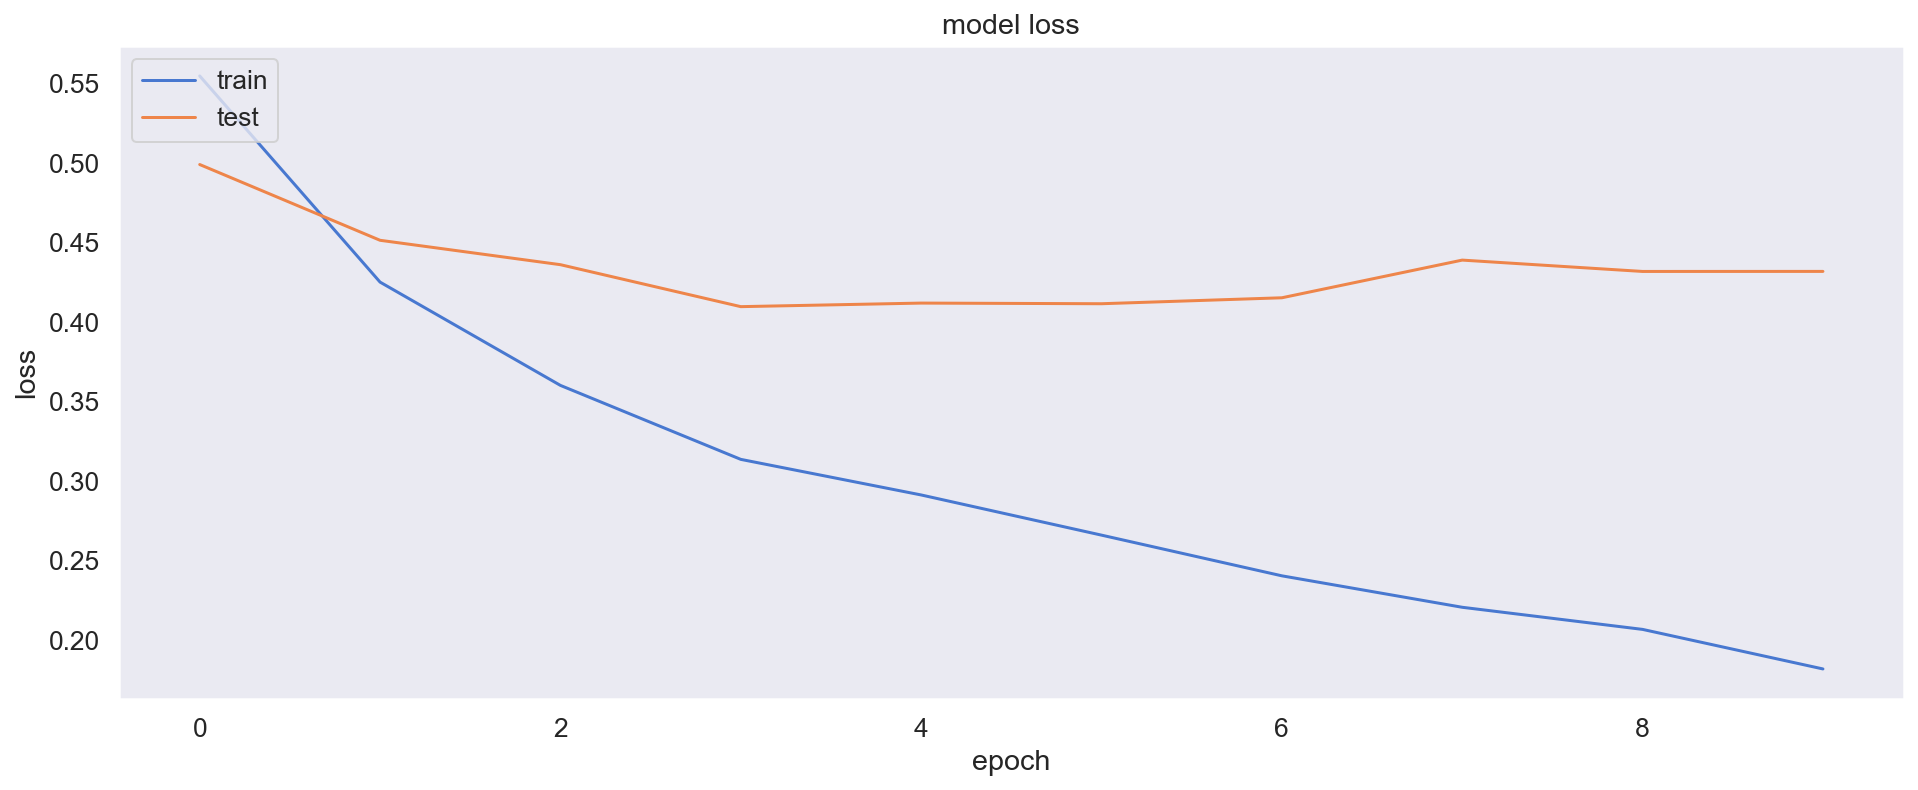

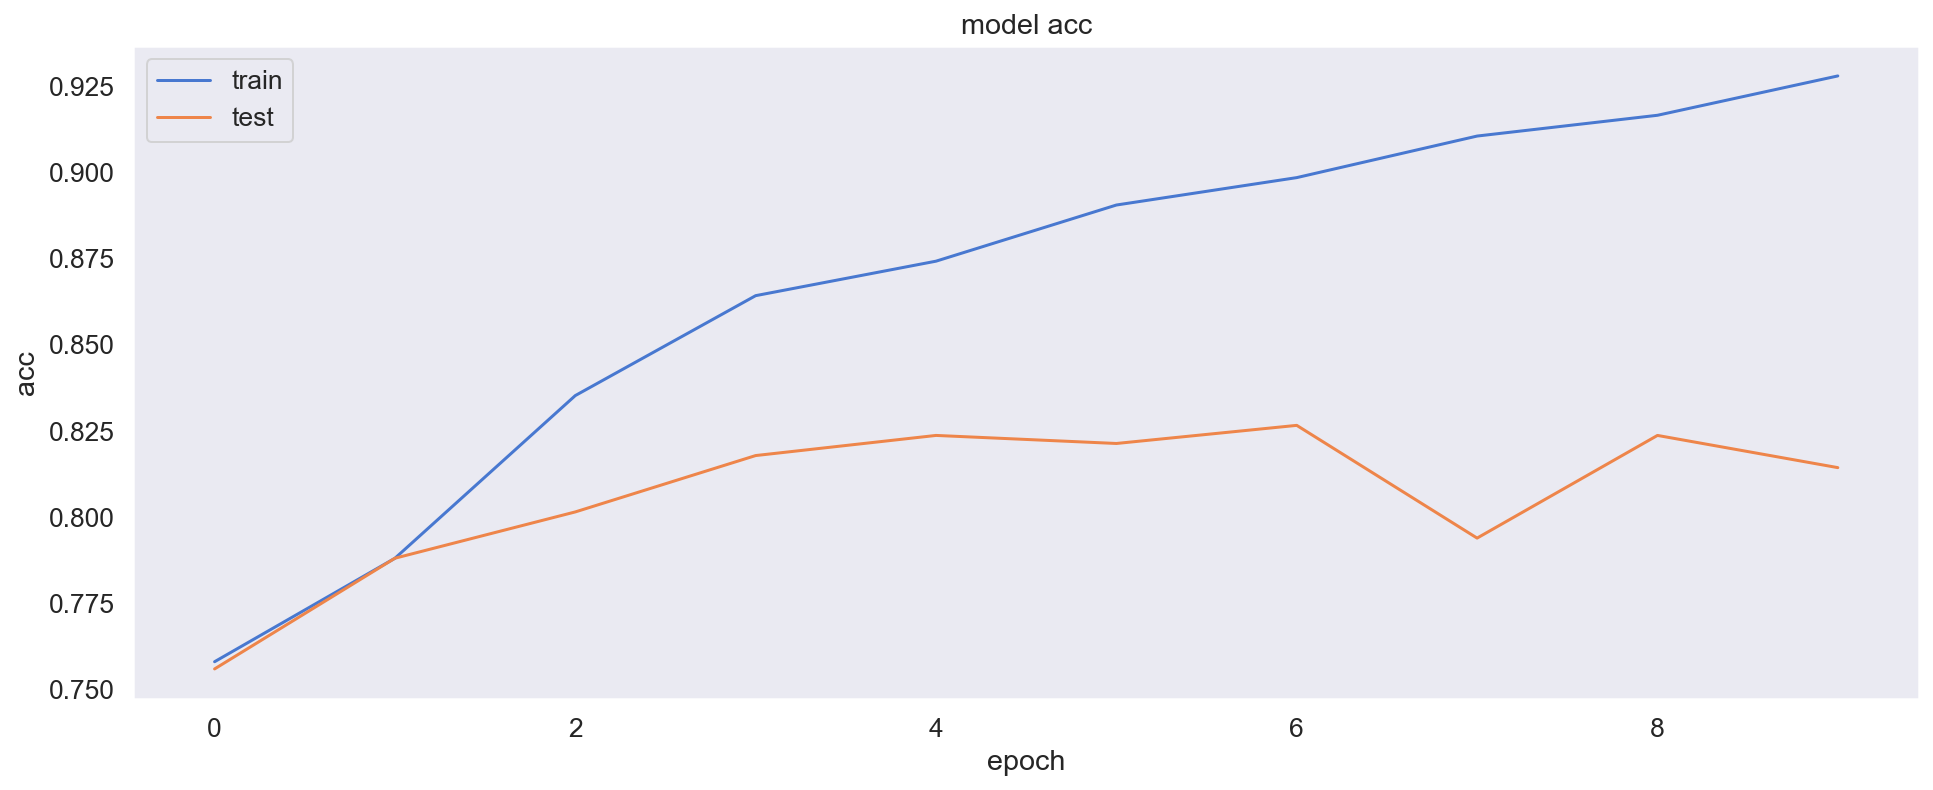

In [60]:
print(cnn_history_v2.history.keys())
plt.plot(cnn_history_v2.history['loss'])
plt.plot(cnn_history_v2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(cnn_history_v2.history['acc'])
plt.plot(cnn_history_v2.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### CNN binary classifier v3 - Widen the network

In the third iteration, I will double the number of filters present in the previous model

In [61]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

l_cov1= Conv1D(128, 5, activation='relu')(embedded_sequences)
l_pool1 = MaxPooling1D(5, data_format='channels_first')(l_cov1)
l_drop1 = Dropout(0.5)(l_pool1)

l_cov2 = Conv1D(128, 5, activation='relu')(l_drop1)
l_pool2 = MaxPooling1D(5, data_format='channels_first')(l_cov2)
l_drop2 = Dropout(0.5)(l_pool2)

l_cov3 = Conv1D(256, 5, activation='relu')(l_drop2)
l_pool3 = MaxPooling1D(35, data_format='channels_first')(l_cov3)  # global max pooling
l_flat = Flatten()(l_pool3)

l_dense = Dense(128, activation='relu')(l_flat)
preds = Dense(2, activation='softmax')(l_dense)

model_2n_v3 = Model(sequence_input, preds)

model_2n_v3.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

model_2n_v3.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 200, 100)          1751900   
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 196, 128)          64128     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 196, 25)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 196, 25)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 192, 128)          16128     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 192, 25)           0   

In [62]:
model_2n_v3.save_weights('cnn_2n_v3_initialized_weights.h5')

In [63]:
cnn_history_v3 = model_2n_v3.fit(X_train, y_train_re, validation_data=(X_test, y_test_re), epochs=10, batch_size=64)

Train on 7800 samples, validate on 1713 samples
Epoch 1/10
7800/7800 [==============================] - 15s 2ms/sample - loss: 0.5465 - acc: 0.7617 - val_loss: 0.4876 - val_acc: 0.7747
Epoch 2/10
7800/7800 [==============================] - 15s 2ms/sample - loss: 0.3292 - acc: 0.8567 - val_loss: 0.5515 - val_acc: 0.7840
Epoch 3/10
7800/7800 [==============================] - 15s 2ms/sample - loss: 0.2686 - acc: 0.8890 - val_loss: 0.4328 - val_acc: 0.8196
Epoch 4/10
7800/7800 [==============================] - 14s 2ms/sample - loss: 0.2364 - acc: 0.9009 - val_loss: 0.4291 - val_acc: 0.8196
Epoch 5/10
7800/7800 [==============================] - 15s 2ms/sample - loss: 0.2224 - acc: 0.9092 - val_loss: 0.4915 - val_acc: 0.8050
Epoch 6/10
7800/7800 [==============================] - 15s 2ms/sample - loss: 0.2036 - acc: 0.9204 - val_loss: 0.4612 - val_acc: 0.8219
Epoch 7/10
7800/7800 [==============================] - 14s 2ms/sample - loss: 0.1753 - acc: 0.9312 - val_loss: 0.5120 - val_acc: 

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


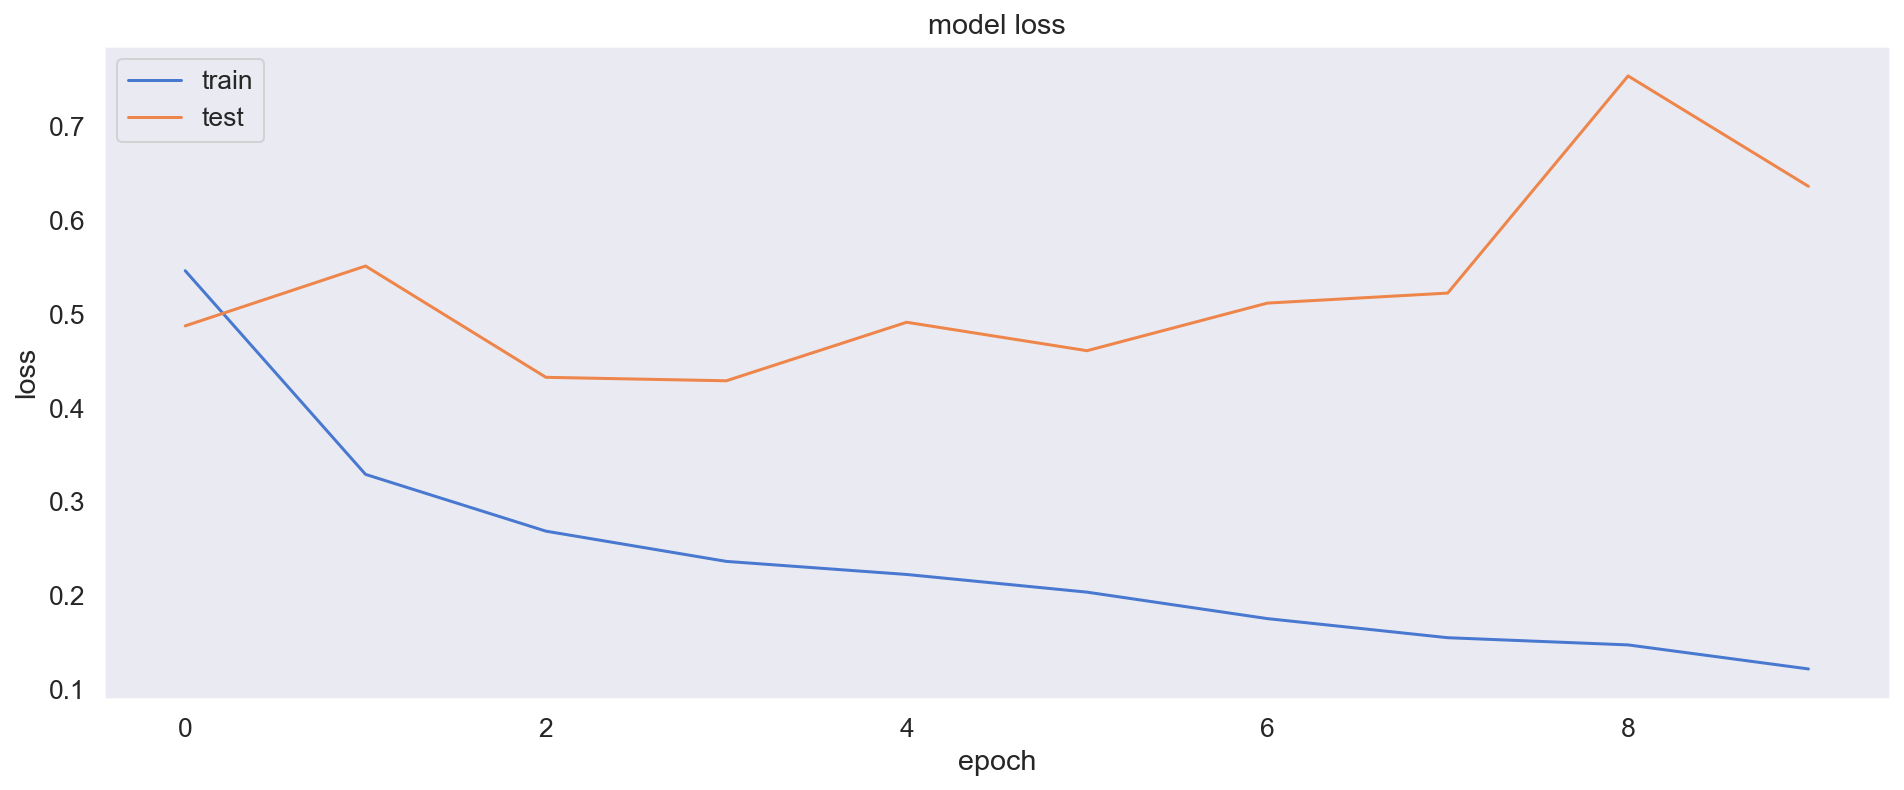

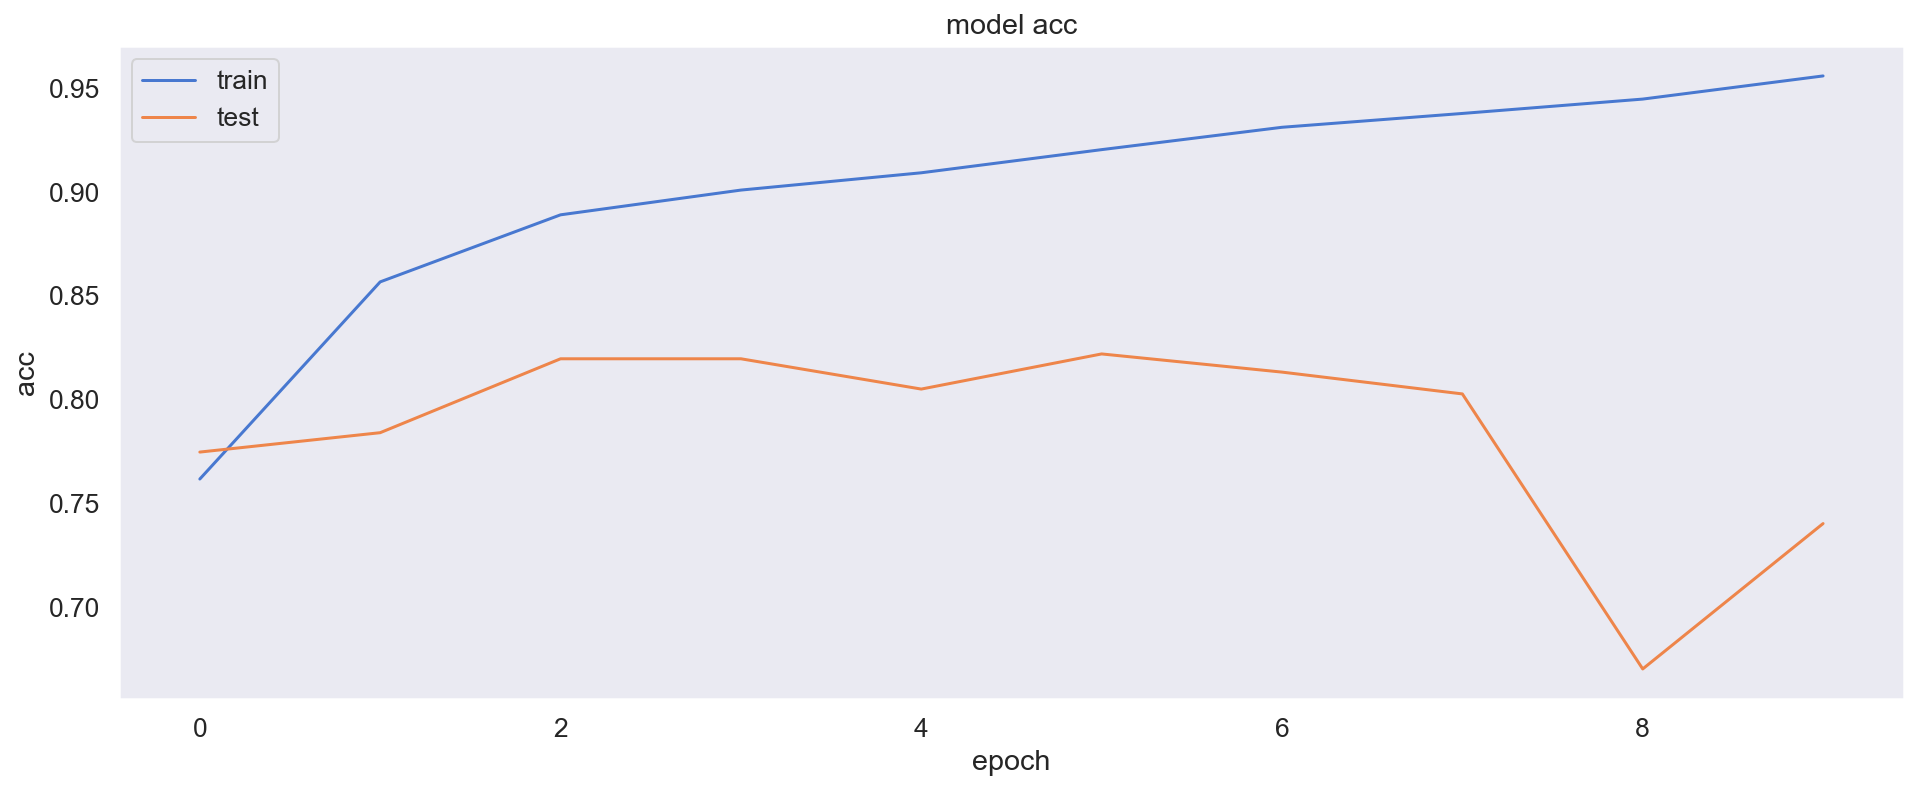

In [64]:
print(cnn_history_v3.history.keys())
plt.plot(cnn_history_v3.history['loss'])
plt.plot(cnn_history_v3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(cnn_history_v3.history['acc'])
plt.plot(cnn_history_v3.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## CNN Models - Initial Evaluations

In [65]:
scores_cnn_v1 = model_2n.evaluate(X_test, y_test_re, verbose=1)

1713/1713 [==============================] - 0s 194us/sample - loss: 3.1678 - acc: 0.7694


In [66]:
scores_cnn_v2 = model_2n_v2.evaluate(X_test, y_test_re, verbose=1)

1713/1713 [==============================] - 0s 206us/sample - loss: 0.6718 - acc: 0.7963


In [67]:
scores_cnn_v3 = model_2n_v3.evaluate(X_test, y_test_re, verbose=1)

1713/1713 [==============================] - 1s 384us/sample - loss: 0.6365 - acc: 0.7402


In [68]:
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import classification_report

print('-'*64)
print('Basic CNN')
print('-'*64)
y_pred_1 = model_2n.predict(X_test)
print(classification_report(np.argmax(y_test_re, axis=1), np.argmax(y_pred_1, axis=1)))


print('-'*64)
print('Basic CNN with Dropout')
print('-'*64)

y_pred_2 = model_2n_v2.predict(X_test)
print(classification_report(np.argmax(y_test_re, axis=1), np.argmax(y_pred_2, axis=1)))

print('-'*64)
print('Basic CNN with Dropout and 2X filters')
print('-'*64)

y_pred_3 = model_2n_v3.predict(X_test)
print(classification_report(np.argmax(y_test_re, axis=1), np.argmax(y_pred_3, axis=1)))

----------------------------------------------------------------
Basic CNN
----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.06      0.11       418
           1       0.77      1.00      0.87      1295

    accuracy                           0.77      1713
   macro avg       0.85      0.53      0.49      1713
weighted avg       0.81      0.77      0.68      1713

----------------------------------------------------------------
Basic CNN with Dropout
----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.75      0.25      0.37       418
           1       0.80      0.97      0.88      1295

    accuracy                           0.80      1713
   macro avg       0.78      0.61      0.62      1713
weighted avg       0.79      0.80      0.75      1713

-----------------------------------------------------

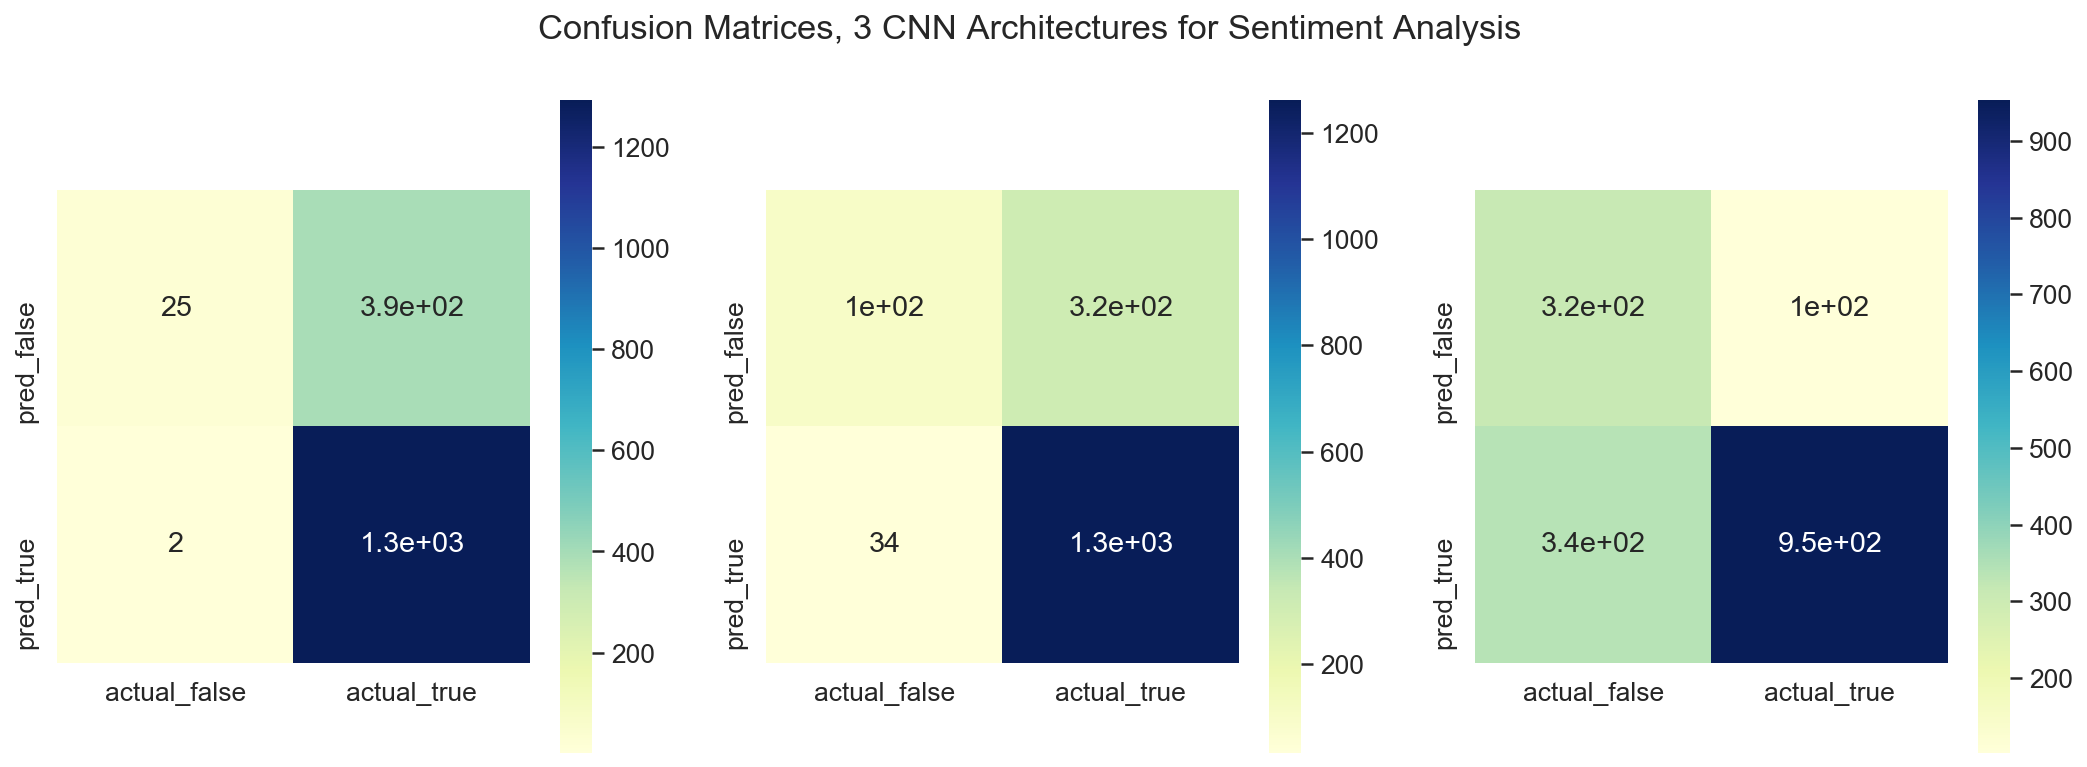

In [69]:
confusion_matrix_1 = cm(y_test_re.argmax(axis=1), y_pred_1.argmax(axis=1))
confusion_matrix_2 = cm(y_test_re.argmax(axis=1), y_pred_2.argmax(axis=1))
confusion_matrix_3 = cm(y_test_re.argmax(axis=1), y_pred_3.argmax(axis=1))

with sns.axes_style("white"):
    f, ax = plt.subplots(ncols=3, figsize=(18, 6))
    plt.suptitle('Confusion Matrices, 3 CNN Architectures for Sentiment Analysis')
    sns.heatmap(confusion_matrix_1, square=True, annot=True, cmap="YlGnBu", ax=ax[0], xticklabels=['actual_false', 'actual_true'], yticklabels=['pred_false', 'pred_true'])
    sns.heatmap(confusion_matrix_2, square=True, annot=True, cmap="YlGnBu", ax=ax[1], xticklabels=['actual_false', 'actual_true'], yticklabels=['pred_false', 'pred_true'])
    sns.heatmap(confusion_matrix_3, square=True, annot=True, cmap="YlGnBu", ax=ax[2], xticklabels=['actual_false', 'actual_true'], yticklabels=['pred_false', 'pred_true'])

### Inspect reviews that were classified incorrectly


In [105]:
text = tokenizer.sequences_to_texts(X_test)

false_pos = []
false_neg = []

for i, pair in enumerate(zip(y_test_re.argmax(axis=1), y_pred_1.argmax(axis=1))):
    if pair[0] == pair[1]:
        continue
    if pair[0] == 1:
        false_neg.append(text[i])
    false_pos.append(text[i])

In [106]:
len(false_pos)

395

In [107]:
len(false_neg)

2

In [109]:
for i, review in enumerate(false_neg):
    print(review)
    print('----')
    if i == 10:
        break
        
for i, review in enumerate(false_pos):
    print(review)
    print('----')
    if i == 10:
        break

found this coffee flavorful bold didn experience bitterness reference purposes store drink starbucks americano favorite cups starbucks french roast starbucks caffe verona starbucks pike place roast green mountain xtra bold sumatran reserve green mountain double black diamond green mountain revv green mountain dark magic other cups tried coffee people fuel green mountain dark magic decaf emeril jazzed decaf starbucks caffe verona coffee people black tiger starbucks house blend starbucks breakfast blend starbucks sumatra wolfgang puck french roast green mountain lake lodge green mountain french roast caribou mahogony wolfgang puck sumatra kopi raya emeril easy bold
----
love this soup have been eating this soup long time have tried several different soups with these same types ingredients this best however will order from amazon again ordered case different times first time cans were dented second order postal worker delivered plastic trash because cans were busted open other cans were d

## SMOTE for oversampling the minority class

Our data is heavily imbalanced toward positive reviews.  Let's use SMOTE to rebalance.

In [74]:
from imblearn.over_sampling import SMOTE

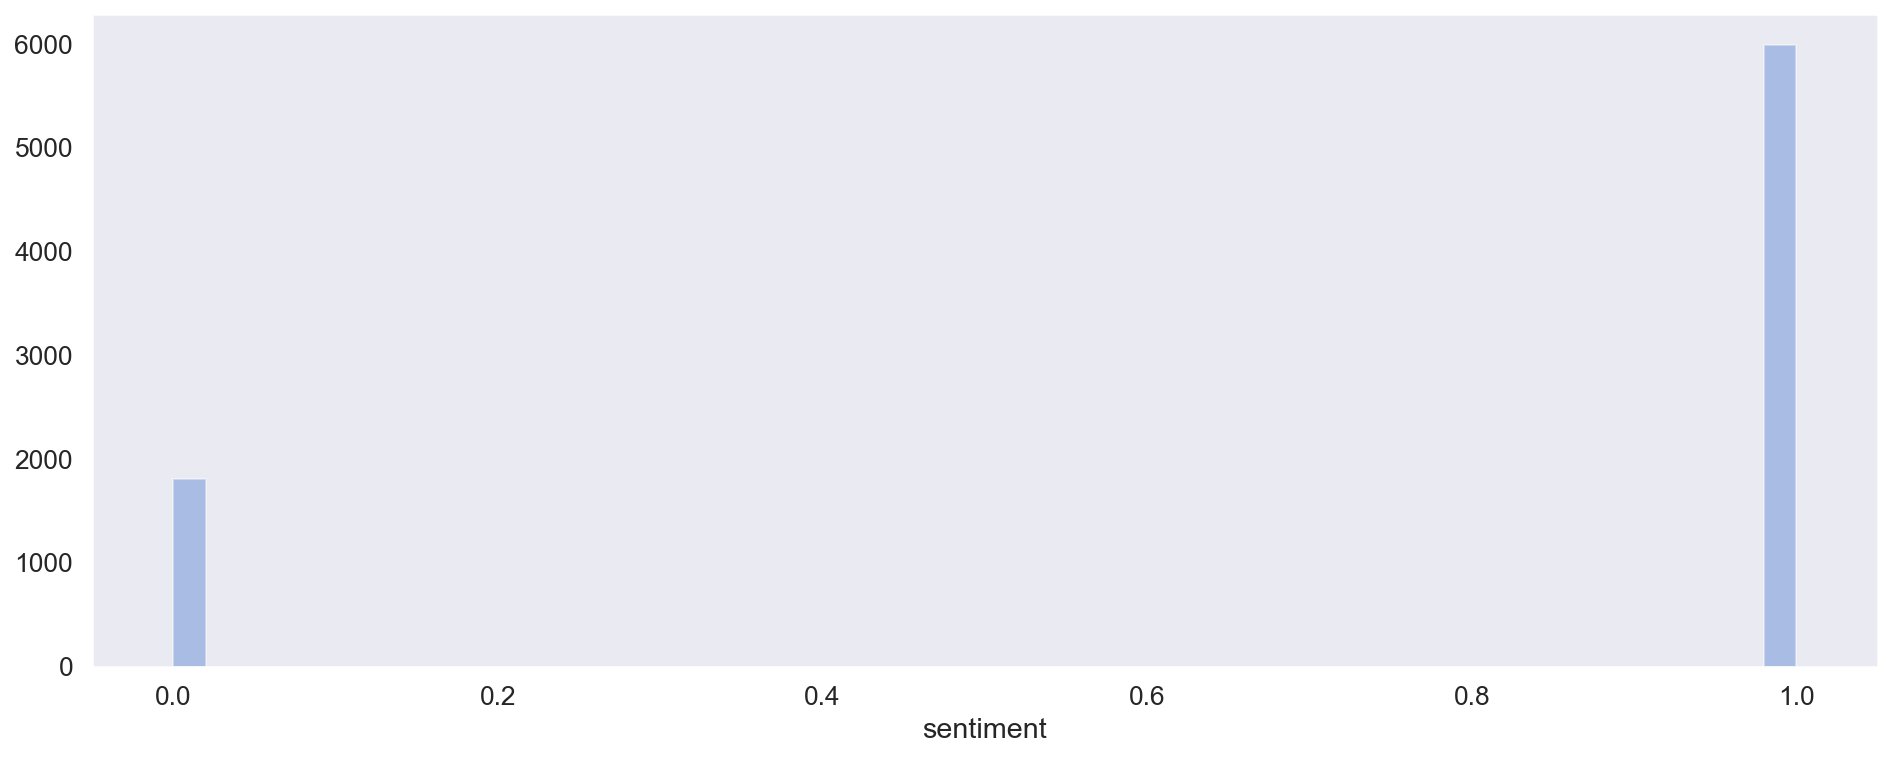

In [75]:
sns.distplot(y_train, kde=False)

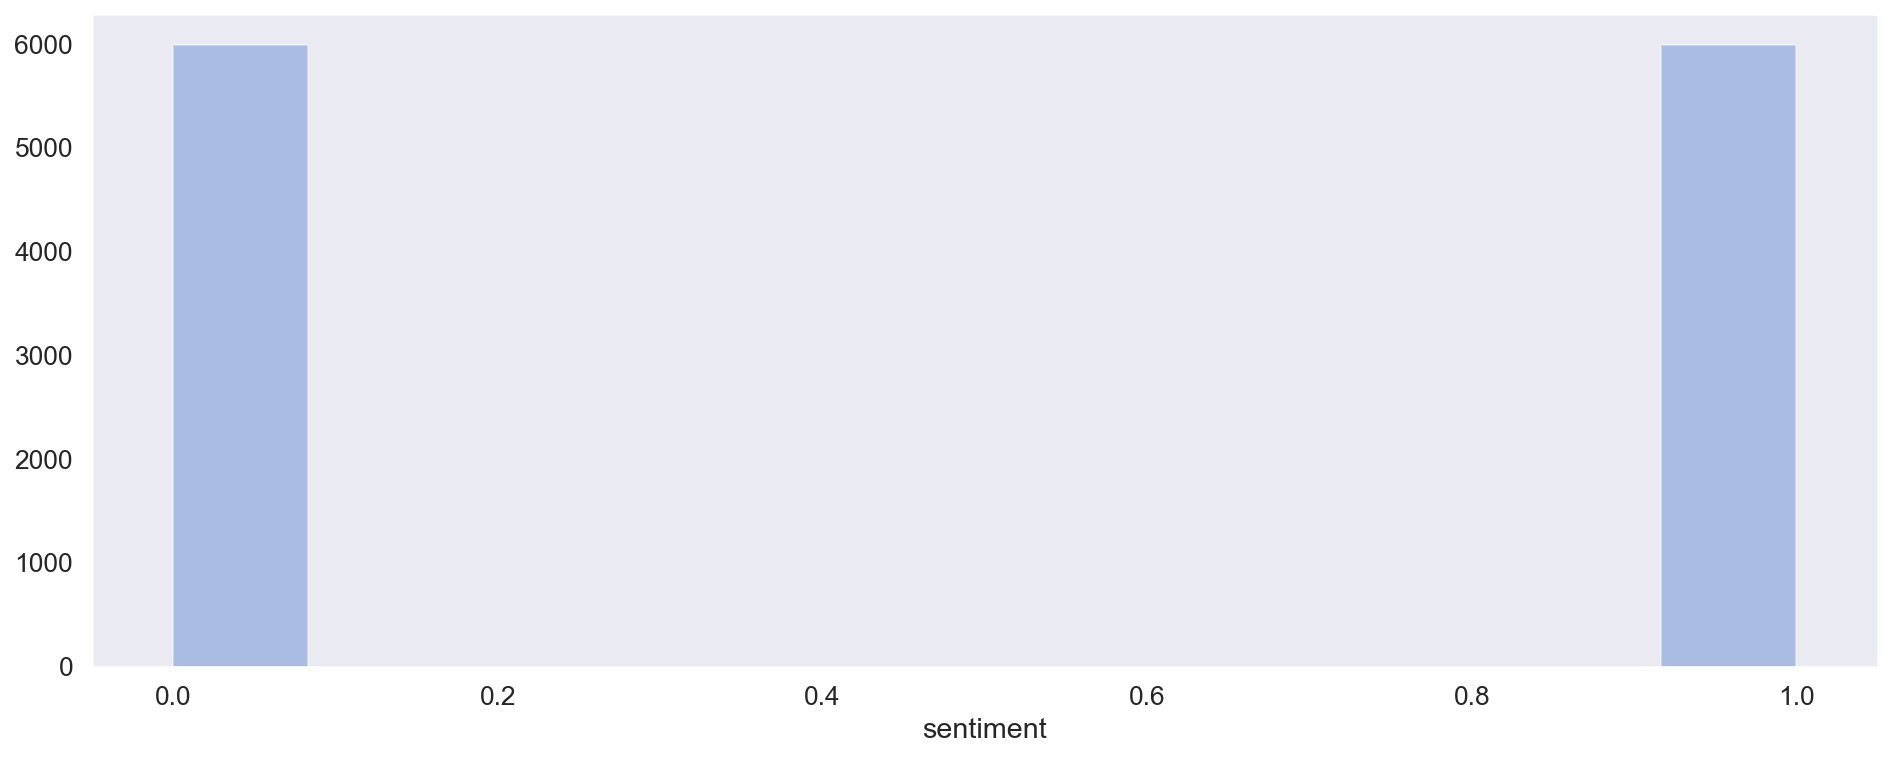

In [76]:
oversample = SMOTE()

X_train, y_train = oversample.fit_resample(X_train, y_train)
sns.distplot(y_train, kde=False)

In [77]:
y_train_re = to_categorical(y_train)
y_test_re = to_categorical(y_test)

In [78]:
model_2n_v2.load_weights('cnn_2n_v2_initialized_weights.h5')

In [79]:
cnn_history_v2_smote = model_2n_v2.fit(X_train, y_train_re, validation_data=(X_test, y_test_re), epochs=10, batch_size=64)

Train on 11976 samples, validate on 1713 samples
Epoch 1/10
11976/11976 [==============================] - 14s 1ms/sample - loss: 0.7112 - acc: 0.5478 - val_loss: 0.6236 - val_acc: 0.7560
Epoch 2/10
11976/11976 [==============================] - 15s 1ms/sample - loss: 0.6786 - acc: 0.5724 - val_loss: 0.6537 - val_acc: 0.6608
Epoch 3/10
11976/11976 [==============================] - 17s 1ms/sample - loss: 0.6311 - acc: 0.6430 - val_loss: 0.5824 - val_acc: 0.7081
Epoch 4/10
11976/11976 [==============================] - 15s 1ms/sample - loss: 0.5593 - acc: 0.7107 - val_loss: 0.5870 - val_acc: 0.7104
Epoch 5/10
11976/11976 [==============================] - 16s 1ms/sample - loss: 0.5099 - acc: 0.7544 - val_loss: 0.5793 - val_acc: 0.6912
Epoch 6/10
11976/11976 [==============================] - 17s 1ms/sample - loss: 0.4618 - acc: 0.7869 - val_loss: 0.7631 - val_acc: 0.5505
Epoch 7/10
11976/11976 [==============================] - 15s 1ms/sample - loss: 0.4205 - acc: 0.8097 - val_loss: 0.5

In [80]:
scores_cnn_v2_smote = model_2n_v2.evaluate(X_test, y_test_re, verbose=1)

1713/1713 [==============================] - 0s 221us/sample - loss: 0.4986 - acc: 0.7612


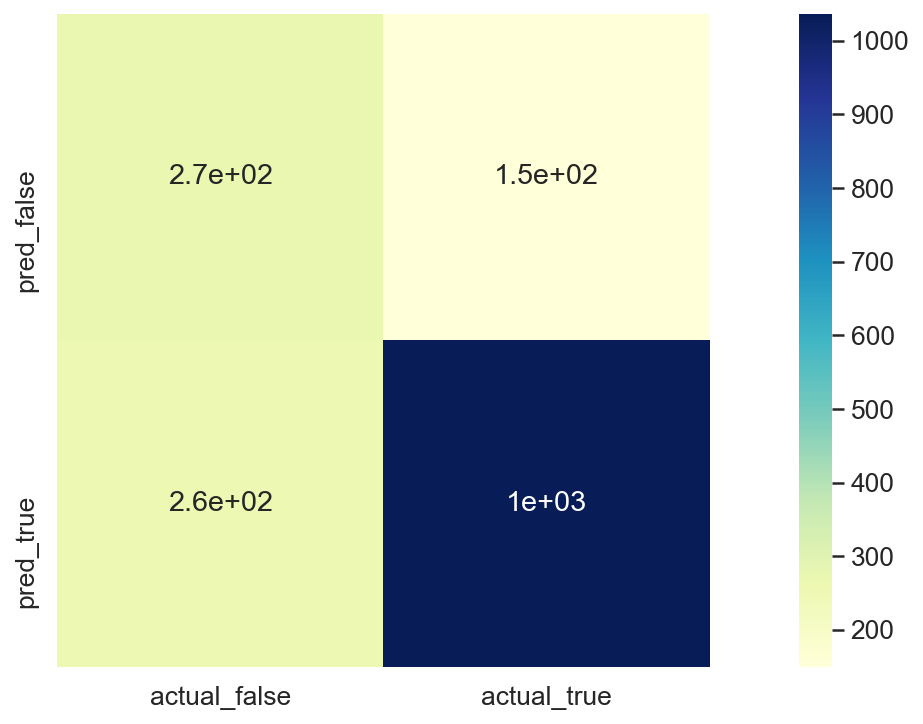

In [81]:
from sklearn.metrics import confusion_matrix as cm

y_pred_2_smote = model_2n_v2.predict(X_test)
confusion_matrix_4 = cm(y_test_re.argmax(axis=1), y_pred_2_smote.argmax(axis=1))
sns.heatmap(
    confusion_matrix_4, 
    square=True, 
    annot=True, 
    cmap="YlGnBu", 
    xticklabels=['actual_false', 'actual_true'], 
    yticklabels=['pred_false', 'pred_true'])

In [82]:
print('-'*64)
print('Basic CNN with Dropout, SMOTE rebalanced data set')
print('-'*64)

print(classification_report(np.argmax(y_test_re, axis=1), np.argmax(y_pred_2_smote, axis=1)))

----------------------------------------------------------------
Basic CNN with Dropout, SMOTE rebalanced data set
----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.51      0.64      0.57       418
           1       0.87      0.80      0.84      1295

    accuracy                           0.76      1713
   macro avg       0.69      0.72      0.70      1713
weighted avg       0.78      0.76      0.77      1713



## Null Accuracy (Predict the most common rating)

Here I would like to compare the accuracy of a null classifier - that is, an entirely naive classifier that simply predicts the most common rating.

In [83]:
null_vec = np.full((len(y_test),), 1)

In [84]:
print('-'*64)
print('Null classifier')
print('-'*64)
print(classification_report(np.argmax(y_test_re, axis=1), null_vec))

----------------------------------------------------------------
Null classifier
----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       418
           1       0.76      1.00      0.86      1295

    accuracy                           0.76      1713
   macro avg       0.38      0.50      0.43      1713
weighted avg       0.57      0.76      0.65      1713



## TFIDF Vectors

In [ ]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec

In [ ]:
snow = SnowballStemmer('english')
stops = stopwords.words('english')

# Tokenize, drop stopwords, stem

def stem_tokenize_sents(sents):
    """
    stems and tokenize list of strings
    drops stop words. returns a tuple 
    of stemmed sents and tokenized stemmed 
    sents
    """
    stemmed_sents = []
    stemmed_tokens = []
    for i, sent in enumerate(sents):
        raw_tokens = sent.split()
        local_tokens = []
        for token in raw_tokens:
            if token not in stops:
                local_tokens.append(snow.stem(token))
        stemmed_tokens.append(local_tokens)
        stemmed_sents.append(' '.join(raw_tokens))
    return stemmed_sents, stemmed_tokens

In [ ]:
# get cleaned sentences as strings and as lilst of tokens
# clean_sents, clean_tokenized_sents = stem_tokenize_sents(sents)

In [ ]:
tf_idf = TfidfVectorizer(binary=True, max_features=6000, min_df=7, max_df=0.8, ngram_range=(1, 3))
tf_data = tf_idf.fit_transform(df['review_clean']).toarray()

In [ ]:
tf_idf.vocabulary_['highly recommend']

In [ ]:
tf_data[:3]

In [ ]:
len(tf_idf.vocabulary_)

In [ ]:
# each vector is size of vocabulary
i = 0
while i <= 2:
    print(len(tf_data[i]))
    i+=1

In [ ]:
# number of records
len(tf_data)

## Non-CNN Classifiers

### Random Forest

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [ ]:
text_classifier = RandomForestClassifier(n_estimators=250, random_state=0)
text_classifier.fit(X_train, y_train)

In [ ]:
# Make predictions on test data
predictions = text_classifier.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_test, predictions)
print('Confusion Matrix')
print(cf_matrix)
print('\n\n')

print('Classification Report')
print(classification_report(y_test, predictions))
print('\n\n')

print('Accuracy')
print(accuracy_score(y_test, predictions))

### Gaussian Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
text_classifier = GaussianNB()
text_classifier.fit(X_train, y_train)

In [ ]:
predictions = text_classifier.predict(X_test)

In [ ]:
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
logreg = LogisticRegression(C=1e5)
logreg.fit(X_train, y_train)

In [ ]:
predictions = logreg.predict(X_test)

In [ ]:
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

## Simpler Neural Network Approaches

### Neural Network, basic multilayer perceptron with Dropout, discrete output

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.initializers import he_normal, RandomNormal

In [ ]:
model = Sequential()
model.add(Dense(100, activation='relu', input_dim=len(tf_idf.vocabulary_)))
model.add(Dropout(0.5))
model.add(Dense(250, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

### Neural Network, basic multilayer perceptron with Dropout, continuous output

In [ ]:
from tensorflow.keras.optimizers import RMSprop

optimizer = RMSprop(0.001)
    
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=len(tf_idf.vocabulary_)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))
model.compile(optimizer=optimizer, loss='mse', metrics=['mse'])

In [ ]:
y_train[:8]

In [ ]:
y_train_cont = np.true_divide(y_train, 5).to_numpy()
y_train_cont[:8]

In [ ]:
y_1 = np.true_divide(y_test, 5).to_numpy()
y_1[:8]

In [ ]:
history = model.fit(X_train, y_train_cont, validation_data=(X_test, y_1), epochs=3, batch_size=16)

In [ ]:
act = y_1[7:20]

In [ ]:
res = model.predict(X_test)

In [ ]:
sns.scatterplot(y_1.flatten(), res.flatten())
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")

In [ ]:
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Sentiment Analysis

### Crude Sentiment Analysis

In [ ]:
positive_words = [
    'good', 'great', 'love', 'loved', 'fantastic', 
    'delicious', 'excellent', 'satisfied', 'well', 'nice', 
    'perfect', 'perfectly', 'thanks', 'thank', 'tasty', 'fun'
]

negative_words = [
    'bad', 'horrible', 'disappointed', 'damaged', 
    'terrible', 'hate', 'garbage', 'worthless',
    'cheap', 'wrong', 'frustrating', 'frustrated',
    'disgusting', 'gross', 'horrible', 'nasty',
    'spoiled', 'stale', 'watery'
]

def sum_count_in_list(words, word_list):
    count = 0
    for word in words:
        if word in word_list:
            count += 1
    return count

In [ ]:
df['pos_word_count'] = df['review_tokens'].apply(lambda x: sum_count_in_list(x, positive_words))
df['neg_word_count'] = df['review_tokens'].apply(lambda x: sum_count_in_list(x, negative_words))

In [ ]:
df.head(3)

In [ ]:
df_corr = df[['pos_word_count', 'neg_word_count', 'review_length', 'score']].corr()
df_corr

In [ ]:
sns.heatmap(df_corr, annot=True)